In [ ]:
!nvidia-smi

Thu Apr 28 16:38:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch; print(torch.__version__)


1.10.0+cu113


In [ ]:
%pip install torch==1.10.0+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html


Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-1.11.0+cpu.html
     |████████████████████████████████| 291 kB 37.4 MB/s 
     |████████████████████████████████| 635 kB 19.2 MB/s 
     |████████████████████████████████| 320 kB 49.6 MB/s 
     |████████████████████████████████| 140 kB 30.5 MB/s 
     |████████████████████████████████| 407 kB 22.5 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=97649b94335bbe81bf988c0b6f19b0352b3c91271b1bf1fb04bc3a9c46ecbda6
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [ ]:
%pip install torch==1.10.0+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


In [59]:
import torch
import networkx as nx
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

from sklearn import mixture

from matplotlib.patches import Ellipse
import statistics

from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader

from collections import Counter

from sklearn import svm
from sklearn.metrics import accuracy_score, roc_auc_score


In [153]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [154]:
import glob
all_samples = glob.glob(glob.escape("/content/drive/My Drive/tensor") + "/*.pt")

In [155]:
class AGGDataset(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self):
        'Initialization'
        self.samples = all_samples
                        
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.samples)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.samples[index]
        all_data = torch.load(ID)

        return all_data

In [156]:
AGG_Dataset =  AGGDataset()
train_size = int(0.65 * len(AGG_Dataset))
valid_size = int(0.05 * len(AGG_Dataset))
test_size = len(AGG_Dataset) - train_size - valid_size
AGG_Dataset_train, AGG_Dataset_valid, AGG_Dataset_test = torch.utils.data.random_split(AGG_Dataset, [train_size, valid_size, test_size], torch.manual_seed(42)) #0

# # Check train dataset
# train_classes = [label for label in AGG_Dataset_train]
# # Counter(train_classes)

# # Check train dataset
# valid_classes = [label for label in AGG_Dataset_valid]
# # Counter(train_classes)

# # Check test dataset
# test_classes = [label for label in AGG_Dataset_test]
# # Counter(train_classes)

In [146]:
###### GMM plot
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None): #inverse_flag,
    X = np.array(X)[:,0:2]
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    # if inverse_flag == 1:
    labels ^= 1

    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        
        draw_ellipse(pos, covar, alpha=w * w_factor)

def plot_real(outputs, real_labels, ax=None):
    X = np.array(outputs)[:,0:2]
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c= real_labels, s=40, cmap='viridis', zorder=2)
    ax.axis('equal')


In [118]:
def evaluate(loader):
    model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
        for data in loader:

            data = data.to(device)
            pred = model(data).detach().cpu().numpy()
            pred = np.mean(pred, axis=0).T.tolist()

            label =torch.t(data.y)[0][0].to(torch.float32).detach().cpu().numpy().tolist()
            predictions.extend(pred)
            labels.append(label)
            
        return predictions, labels

In [148]:
def check_with_SVM():
    # train
    train_pred, train_labels = evaluate(AGG_Dataset_train)  
    X = np.array(train_pred)[:,0:2]
    y = train_labels
    clf = svm.SVC(kernel='linear', probability=True)
    clf.fit(X, y)
    check_pred_train = clf.predict(X)

    train_accuracy = accuracy_score(train_labels, check_pred_train)
    train_AUC = roc_auc_score(train_labels, clf.predict_proba(X)[:,1])
    print("train_accuracy", train_accuracy)
    print("train_AUC", train_AUC)

    w = clf.coef_[0]
    k = -w[0] / w[1]
    b = - clf.intercept_[0] / w[1]
    print("linear", k, b)


    # valid
    valid_pred, valid_labels = evaluate(AGG_Dataset_valid)  
    X_v = np.array(valid_pred)[:,0:2]
    y_v = valid_labels
    check_pred_valid = clf.predict(X_v)

    valid_accuracy = accuracy_score(valid_labels, check_pred_valid)
    valid_AUC = roc_auc_score(valid_labels, clf.predict_proba(X_v)[:,1])
    print("valid_accuracy", valid_accuracy)
    print("valid_AUC", valid_AUC)

    # train
    test_pred, test_labels = evaluate(AGG_Dataset_test)  
    X_t = np.array(test_pred)[:,0:2]
    y_t = test_labels
    check_pred_test = clf.predict(X_t)

    test_accuracy = accuracy_score(test_labels, check_pred_test)
    test_AUC = roc_auc_score(test_labels, clf.predict_proba(X_t)[:,1])
    print("test_accuracy", test_accuracy)
    print("test_AUC", test_AUC)

    return train_accuracy, train_AUC, valid_accuracy, valid_AUC, test_accuracy, test_AUC

In [149]:
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, degree

class SAGEConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(SAGEConv, self).__init__(aggr='max', flow="source_to_target", node_dim=-3) #  "Max" aggregation.
        
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.act = torch.nn.ReLU()
        self.update_lin = torch.nn.Linear(in_channels + out_channels, in_channels, bias=False) #
        self.update_act = torch.nn.ReLU()
        
    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)
        
        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message_and_aggregate(self, x_j):
        x_j = self.lin(x_j)
        x_j = self.act(x_j)

        return x_j

    def update(self, aggr_out, x):
        # aggr_out has shape [N, out_channels]
        new_embedding = torch.cat([aggr_out, x], dim=2)
        new_embedding = self.update_lin(new_embedding) 
        new_embedding = self.update_act(new_embedding)
        
        return new_embedding

In [157]:
embed_dim = 25
from torch_geometric.nn import TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(3, 1)

        self.conv1 = SAGEConv(embed_dim, embed_dim)
        self.conv2 = SAGEConv(embed_dim, embed_dim)
        self.item_embedding = torch.nn.Embedding(num_embeddings=4500, embedding_dim=embed_dim)  #num_embeddings=df.item_id.max() +1
        self.lin1 = torch.nn.Linear(embed_dim, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, 1)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()        
  
    def forward(self, data):
        x_all, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.item_embedding(x_all)   
        
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)      
        x = F.dropout(x, p=0.5, training=self.training)

        x = torch.sigmoid(self.lin3(x)).squeeze(1)

        return x


In [158]:
def train():
    model.train()

    loss_all = 0
    total_batches = 0
    for data in AGGDataset():
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = output.mean(dim=1).squeeze(1)
        label = torch.t(data.y)[0].to(torch.float32).to(device)
        loss = crit(output, label)
        loss.backward()
        loss_all += loss.item()  #2
        total_batches += 1
        optimizer.step()
    return loss_all / total_batches

0
loss 0.6116453286006654
train_accuracy 0.822429906542056
train_AUC 0.911387672020886
linear -156.47602495870308 50.50279644642101
valid_accuracy 0.7837837837837838
valid_AUC 0.8542124542124542
test_accuracy 0.7937219730941704
test_AUC 0.9083943089430895


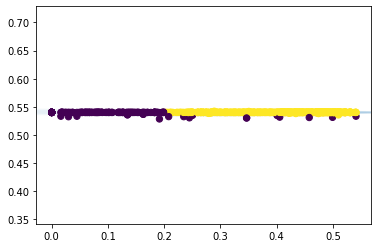

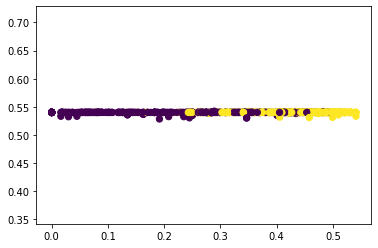

1
loss 0.6869626732509199
train_accuracy 0.5794392523364486
train_AUC 0.48537324660383196
linear -1.0 3355444.2
valid_accuracy 0.527027027027027
valid_AUC 0.4750915750915751
test_accuracy 0.5515695067264574
test_AUC 0.4934349593495935
2
loss 0.6846373575769078
train_accuracy 0.5794392523364486
train_AUC 0.8818730917297226
linear -2.011755027145483 0.9773166911362018
valid_accuracy 0.527027027027027
valid_AUC 0.8388278388278388
test_accuracy 0.5515695067264574
test_AUC 0.8581910569105691
3
loss 0.6774278814858548
train_accuracy 0.8317757009345794
train_AUC 0.9273463427585291
linear -1.9820685609770075 1.194925709228981
valid_accuracy 0.7837837837837838
valid_AUC 0.8827838827838828
test_accuracy 0.804932735426009
test_AUC 0.9275203252032521


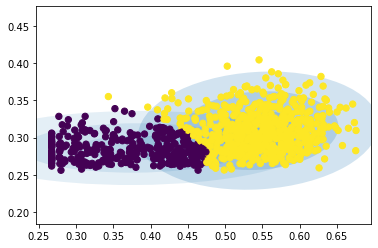

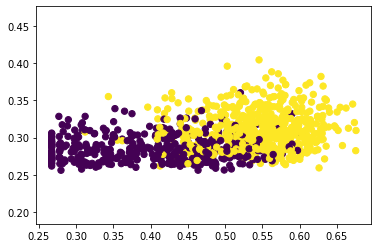

4
loss 0.6546840226417124
train_accuracy 0.8556593977154725
train_AUC 0.9365613522722245
linear -1.201858046744779 1.0677069024431092
valid_accuracy 0.7972972972972973
valid_AUC 0.8989010989010988
test_accuracy 0.8251121076233184
test_AUC 0.9323373983739838
5
loss 0.6423201375287365
train_accuracy 0.9003115264797508
train_AUC 0.9660582326651621
linear -1.0655920376201165 0.7644672338120235
valid_accuracy 0.8378378378378378
valid_AUC 0.9326007326007326
test_accuracy 0.874439461883408
test_AUC 0.9595731707317074
6
loss 0.6040077733173614
train_accuracy 0.9003115264797508
train_AUC 0.9670051772202309
linear -0.6235171769885193 0.7168653736519086
valid_accuracy 0.8783783783783784
valid_AUC 0.9355311355311355
test_accuracy 0.8834080717488789
test_AUC 0.9553861788617886


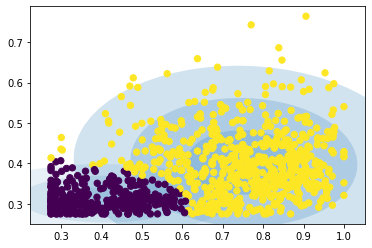

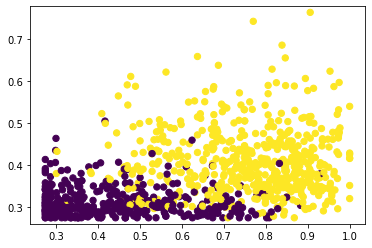

7
loss 0.5883920569819369
train_accuracy 0.8515057113187954
train_AUC 0.9361343422275322
linear -0.6485926485207063 0.5985414169381023
valid_accuracy 0.8243243243243243
valid_AUC 0.926007326007326
test_accuracy 0.8408071748878924
test_AUC 0.9246036585365854
8
loss 0.6363636209746912
train_accuracy 0.8795430944963655
train_AUC 0.9493340413292624
linear -0.7549558591191442 1.0294646156196001
valid_accuracy 0.8783783783783784
valid_AUC 0.9472527472527472
test_accuracy 0.905829596412556
test_AUC 0.9602032520325203
9
loss 0.6278186254982039
train_accuracy 0.8868120456905504
train_AUC 0.9507765830346476
linear -0.8097900264310153 1.033128022760665
valid_accuracy 0.9054054054054054
valid_AUC 0.9655677655677656
test_accuracy 0.899103139013453
test_AUC 0.9667073170731707


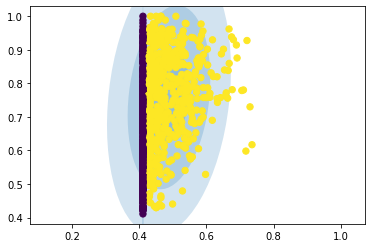

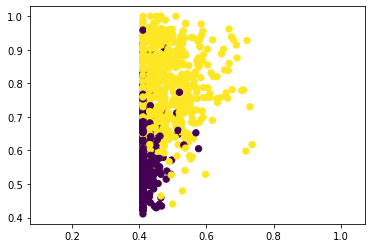

10
loss 0.6220946430717862
train_accuracy 0.8909657320872274
train_AUC 0.9596154697110492
linear -0.7307811359843461 0.9755175286244875
valid_accuracy 0.9324324324324325
valid_AUC 0.9772893772893773
test_accuracy 0.9080717488789237
test_AUC 0.969329268292683
11
loss 0.616905812025874
train_accuracy 0.8909657320872274
train_AUC 0.958553475817514
linear -0.5308969783930108 0.3680060184027051
valid_accuracy 0.918918918918919
valid_AUC 0.9677655677655678
test_accuracy 0.9013452914798207
test_AUC 0.9672967479674797
12
loss 0.618737897837556
train_accuracy 0.90134994807892
train_AUC 0.9665317049426966
linear -0.6904507066571681 1.0154940288685266
valid_accuracy 0.9459459459459459
valid_AUC 0.9736263736263736
test_accuracy 0.9080717488789237
test_AUC 0.9741869918699188


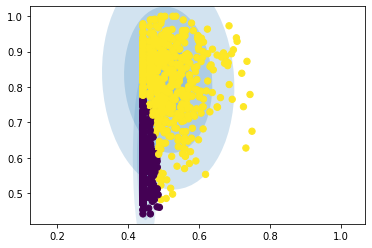

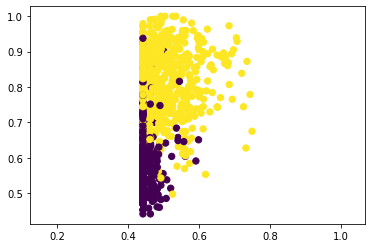

13
loss 0.6140411776702145
train_accuracy 0.9096573208722741
train_AUC 0.967686623301916
linear -0.6678164482945123 0.9879571076633226
valid_accuracy 0.9324324324324325
valid_AUC 0.9772893772893773
test_accuracy 0.9125560538116592
test_AUC 0.9697967479674797
14
loss 0.6151425443383703
train_accuracy 0.9044652128764278
train_AUC 0.9661312447453427
linear -0.7087067770940826 0.9785900837749244
valid_accuracy 0.918918918918919
valid_AUC 0.9794871794871794
test_accuracy 0.9080717488789237
test_AUC 0.9715243902439025
15
loss 0.610799182369672
train_accuracy 0.9138110072689511
train_AUC 0.9682087702995708
linear -0.6465564294739117 0.94188739553987
valid_accuracy 0.918918918918919
valid_AUC 0.9794871794871794
test_accuracy 0.9304932735426009
test_AUC 0.9748983739837399


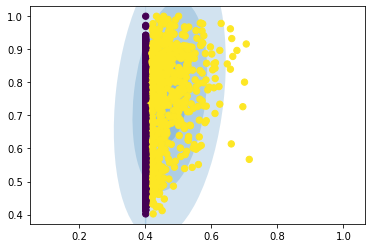

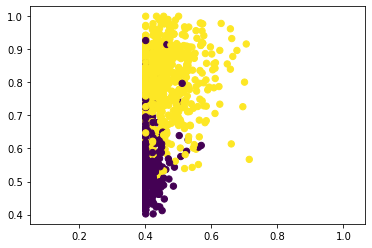

16
loss 0.6091316138982612
train_accuracy 0.9179646936656283
train_AUC 0.9690473029780078
linear -0.6807299534727713 0.9643961866986901
valid_accuracy 0.918918918918919
valid_AUC 0.9838827838827838
test_accuracy 0.9035874439461884
test_AUC 0.9719918699186991
17
loss 0.6070709494184339
train_accuracy 0.9117341640706127
train_AUC 0.9678348599495553
linear -0.7089758618150015 0.904419828992779
valid_accuracy 0.9324324324324325
valid_AUC 0.9692307692307693
test_accuracy 0.905829596412556
test_AUC 0.97369918699187
18
loss 0.611064222782589
train_accuracy 0.9179646936656283
train_AUC 0.9701004469224301
linear -0.6677709971351135 0.9699450880443844
valid_accuracy 0.9324324324324325
valid_AUC 0.9890109890109889
test_accuracy 0.92152466367713
test_AUC 0.9768902439024391


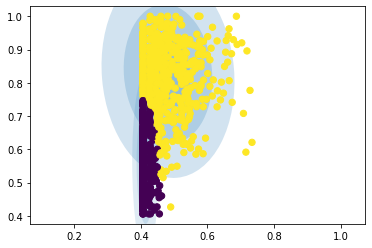

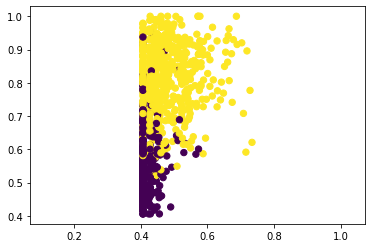

19
loss 0.6077288768617832
train_accuracy 0.9003115264797508
train_AUC 0.9653612991725298
linear -0.6735716497315362 0.8422443818078745
valid_accuracy 0.8918918918918919
valid_AUC 0.9677655677655678
test_accuracy 0.9035874439461884
test_AUC 0.9654776422764229
20
loss 0.776634573573479
train_accuracy 0.9262720664589823
train_AUC 0.9799725651577503
linear -0.7796421663280804 1.210068648265562
valid_accuracy 0.8918918918918919
valid_AUC 0.9692307692307691
test_accuracy 0.9147982062780269
test_AUC 0.9797357723577236
21
loss 0.6351197250011558
train_accuracy 0.9439252336448598
train_AUC 0.9856940572591708
linear -0.7513957914345267 1.1306974285824196
valid_accuracy 0.9054054054054054
valid_AUC 0.9758241758241758
test_accuracy 0.9237668161434978
test_AUC 0.983130081300813


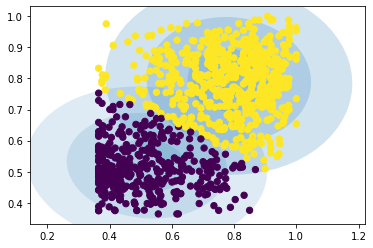

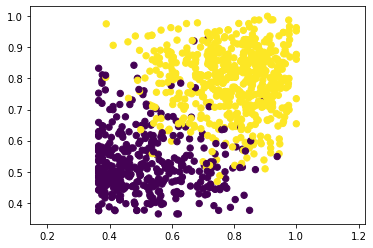

22
loss 0.5685249355823223
train_accuracy 0.944963655244029
train_AUC 0.9865259524757731
linear -0.7025068945622461 1.0084758311204767
valid_accuracy 0.9054054054054054
valid_AUC 0.9736263736263737
test_accuracy 0.9282511210762332
test_AUC 0.9814837398373983
23
loss 0.5733563909037083
train_accuracy 0.9418483904465212
train_AUC 0.9838267179963714
linear -0.720883781112791 1.062894699502571
valid_accuracy 0.8918918918918919
valid_AUC 0.9816849816849818
test_accuracy 0.9260089686098655
test_AUC 0.9788211382113822
24
loss 0.5717968219189088
train_accuracy 0.9325025960539979
train_AUC 0.9794282932873136
linear -0.7639929407299104 1.1827045394891949
valid_accuracy 0.918918918918919
valid_AUC 0.9787545787545787
test_accuracy 0.9170403587443946
test_AUC 0.9765447154471545


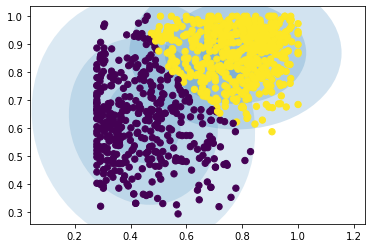

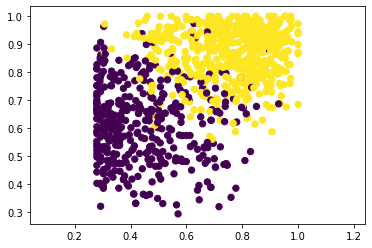

25
loss 0.567032574180486
train_accuracy 0.9428868120456906
train_AUC 0.9864153281118633
linear -0.6982057429144238 1.059208975246272
valid_accuracy 0.8918918918918919
valid_AUC 0.980952380952381
test_accuracy 0.9327354260089686
test_AUC 0.9815853658536585
26
loss 0.611538338002046
train_accuracy 0.8836967808930426
train_AUC 0.9552347449002168
linear -0.4119874712397124 0.20964391103302243
valid_accuracy 0.8783783783783784
valid_AUC 0.9567765567765568
test_accuracy 0.8721973094170403
test_AUC 0.9521239837398374
27
loss 0.7280912304840936
train_accuracy 0.5794392523364486
train_AUC 0.48459666356918446
linear -1.0 -291776.68695652176
valid_accuracy 0.527027027027027
valid_AUC 0.5747252747252748
test_accuracy 0.5515695067264574
test_AUC 0.5135162601626017


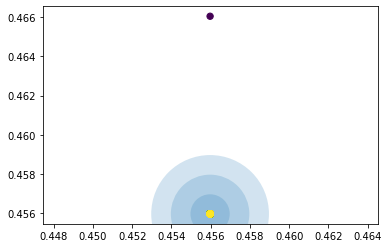

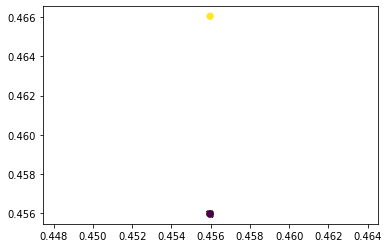

28
loss 0.6884040668134502
train_accuracy 0.5794392523364486
train_AUC 0.4891787247223328
linear -1.0 125204.10447761194
valid_accuracy 0.527027027027027
valid_AUC 0.5296703296703297
test_accuracy 0.5515695067264574
test_AUC 0.5026829268292683
29
loss 0.6860183532665649
train_accuracy 0.5794392523364486
train_AUC 0.5010973936899864
linear -1.0 -266303.75396825396
valid_accuracy 0.527027027027027
valid_AUC 0.4857142857142857
test_accuracy 0.5515695067264574
test_AUC 0.5060569105691057
30
loss 0.6854443708064182
train_accuracy 0.5794392523364486
train_AUC 0.48834019204389567
linear -1.0 838861.95
valid_accuracy 0.527027027027027
valid_AUC 0.5322344322344322
test_accuracy 0.5515695067264574
test_AUC 0.5168292682926829


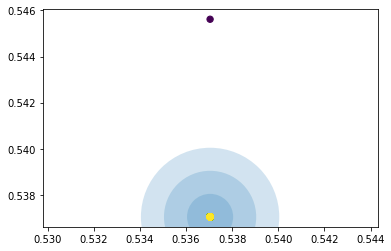

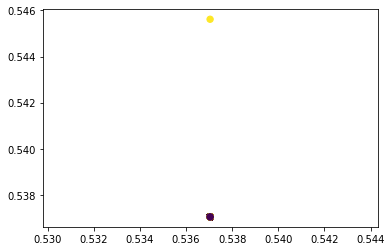

In [159]:
#run
num_epochs = 31

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.BCELoss()
train_score=[]
valid_score=[]
test_score=[]


for epoch in range(num_epochs):
    print(epoch)
    loss = train()
    print("loss", loss)
    train_accuracy, train_AUC, valid_accuracy, valid_AUC, test_accuracy, test_AUC = check_with_SVM()
    train_score.append([train_accuracy, train_AUC])
    valid_score.append([valid_accuracy, valid_AUC])
    test_score.append([test_accuracy, test_AUC])
    if epoch % 3 == 0:
        torch.save(model.state_dict(), 'tensor/GNN_model_' + str(epoch) + '.pkl')
        this_pred, this_labels = evaluate(AGG_Dataset_train)
        gmm = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=42)
        plt.subplots()
        plot_gmm(gmm, this_pred)
        plt.subplots()
        plot_real(this_pred, this_labels)
        plt.show()


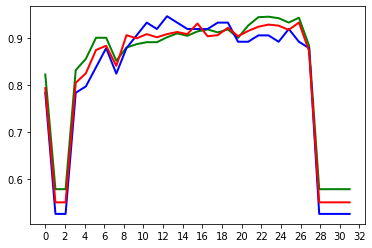

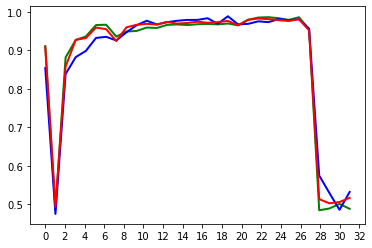

In [160]:
#train_score.append([train_accuracy, train_AUC])
    # valid_score.append([valid_accuracy, valid_AUC])
    # test_score.append([test_accuracy, test_AUC]) 
from matplotlib.pyplot import MultipleLocator

epoch_l = np.linspace(0, 31, 31)
x_majot_locator=MultipleLocator(2)

plt.subplots()
### accuracy
plt.plot(epoch_l, np.array(train_score)[:,0], 'g-', linewidth=2, markersize=12)
plt.plot(epoch_l, np.array(valid_score)[:,0], 'b-', linewidth=2, markersize=12)
plt.plot(epoch_l, np.array(test_score)[:,0], 'r-', linewidth=2, markersize=12)
ax=plt.gca()
ax.xaxis.set_major_locator(x_majot_locator)
plt.show()

plt.subplots()
### auc
plt.plot(epoch_l, np.array(train_score)[:,1], 'g-', linewidth=2, markersize=12)
plt.plot(epoch_l, np.array(valid_score)[:,1], 'b-', linewidth=2, markersize=12)
plt.plot(epoch_l, np.array(test_score)[:,1], 'r-', linewidth=2, markersize=12)
ax=plt.gca()
ax.xaxis.set_major_locator(x_majot_locator)
plt.show()



In [161]:
from google.colab import files

files.download('tensor/GNN_model_24.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

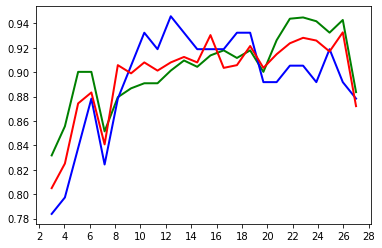

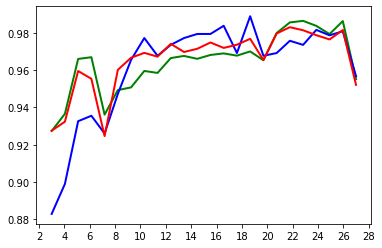

In [162]:
from matplotlib.pyplot import MultipleLocator

min_epoch = 3
max_epoch = 27
epoch_l = np.linspace(min_epoch, max_epoch, 24)
x_majot_locator=MultipleLocator(2)

plt.subplots()
### accuracy
plt.plot(epoch_l, np.array(train_score)[min_epoch:max_epoch,0], 'g-', linewidth=2, markersize=12)
plt.plot(epoch_l, np.array(valid_score)[min_epoch:max_epoch,0], 'b-', linewidth=2, markersize=12)
plt.plot(epoch_l, np.array(test_score)[min_epoch:max_epoch,0], 'r-', linewidth=2, markersize=12)
ax=plt.gca()
ax.xaxis.set_major_locator(x_majot_locator)
plt.show()

plt.subplots()
### auc
plt.plot(epoch_l, np.array(train_score)[min_epoch:max_epoch,1], 'g-', linewidth=2, markersize=12)
plt.plot(epoch_l, np.array(valid_score)[min_epoch:max_epoch,1], 'b-', linewidth=2, markersize=12)
plt.plot(epoch_l, np.array(test_score)[min_epoch:max_epoch,1], 'r-', linewidth=2, markersize=12)
ax=plt.gca()
ax.xaxis.set_major_locator(x_majot_locator)
plt.show()